### 1. Data Setup

In [1]:
# Import Libraries
%pip install -q gymnasium[box2d] stable-baselines3[extra] moviepy

'''
This command will prepare the Python environment with:

The simulation environment (LunarLander),
The reinforcement learning algorithms (DQN and PPO),
And tools for visualization and video recording.
'''

Note: you may need to restart the kernel to use updated packages.


'\nThis command will prepare the Python environment with:\n\nThe simulation environment (LunarLander),\nThe reinforcement learning algorithms (DQN and PPO),\nAnd tools for visualization and video recording.\n'

In [2]:
# Import Libraries
import os, sys, random, time
import warnings
import json

import numpy as np
import torch
import matplotlib.pyplot as plt

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

import imageio
from IPython.display import Image

In [3]:
# GPU or CPU init
USE_GPU = False   # True for GPU

# Device
if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
print("Selected device:", device)
print("CUDA version:", torch.version.cuda if torch.cuda.is_available() else "None")

CUDA available: True
GPU: NVIDIA GeForce RTX 4060
Selected device: cpu
CUDA version: 12.1


In [4]:
# Reproducibility
SEEDS = [42, 62, 82]
TOTAL_TIMESTEPS = 100_000

def seed_setup(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    print("Device:", device)

    return device

# Creates an initialization function for the "LunarLander-v3" environment with a fixed seed
def make_env(seed: int):
    def _init():
        env = gym.make("LunarLander-v3")
        env.reset(seed=seed)
        return env
    return _init

In [5]:
# Outputs and data
BASE_DIR = "./project_results"

# DQN 
DQN_DIR = os.path.join(BASE_DIR, "DQN")
DQN_LOGS = os.path.join(DQN_DIR, "tensorboard")
os.makedirs(DQN_DIR, exist_ok=True)

# PPO 
PPO_DIR = os.path.join(BASE_DIR, "PPO")
PPO_LOGS = os.path.join(PPO_DIR, "tensorboard")
os.makedirs(PPO_DIR, exist_ok=True)

print(f"Results will be saved in: {os.path.abspath(BASE_DIR)}")

Results will be saved in: c:\Users\joaov\Desktop\PG\Code\ATD\ATD_02_DRL\ATD_02\project_results


### 2. Models

In [6]:
class DQNLoggingCallback(BaseCallback):
    """
    Logs epsilon, episodic reward and number of updates during DQN training.
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.epsilon_history = []
        self.reward_history = []
        self.update_steps = []
        self.episode_reward = 0.0

    def _on_step(self) -> bool:
        # Exploration rate (epsilon)
        if hasattr(self.model, "exploration_rate"):
            self.epsilon_history.append(self.model.exploration_rate)

        # Reward
        reward = self.locals.get("rewards")
        if reward is not None:
            self.episode_reward += reward[0]

        # End of episode
        done = self.locals.get("dones")
        if done is not None and done[0]:
            self.reward_history.append(self.episode_reward)
            self.episode_reward = 0.0

        # Gradient updates
        self.update_steps.append(self.model._n_updates)
        return True

In [7]:
class PPOLoggingCallback(BaseCallback):
    """
    Logs entropy, episodic reward, policy loss and value loss during PPO training.
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.entropy_history = []
        self.policy_loss_history = []
        self.value_loss_history = []
        self.reward_history = []
        self.episode_reward = 0.0

    def _on_step(self) -> bool:
        # Reward
        reward = self.locals.get("rewards")
        if reward is not None:
            self.episode_reward += reward[0]

        # End of episode
        done = self.locals.get("dones")
        if done is not None and done[0]:
            self.reward_history.append(self.episode_reward)
            self.episode_reward = 0.0

        # Entropy
        entropy = self.locals.get("ent_coef")  # coef * entropy
        if entropy is not None:
            self.entropy_history.append(entropy)

        # Policy and value loss
        if "loss" in self.locals:
            loss = self.locals["loss"]
            # PPO returns a dict with keys: 'policy_loss', 'value_loss', 'entropy_loss' sometimes
            # We'll try to log if available
            if isinstance(loss, dict):
                self.policy_loss_history.append(loss.get("policy_loss", np.nan))
                self.value_loss_history.append(loss.get("value_loss", np.nan))

        return True

In [8]:
def evaluate_agent(model, env_fn, n_episodes=20, render=False):
    """
    Evaluates an agent over n_episodes deterministically.
    Returns episode rewards and lengths.
    """
    rewards = []
    lengths = []

    env = env_fn()
    for ep in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0.0
        steps = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            steps += 1
            done = terminated or truncated

            if render:
                env.render()

        rewards.append(total_reward)
        lengths.append(steps)

    env.close()
    return np.array(rewards), np.array(lengths)

### 3. Training

In [9]:
dqn_eval_results = {}
ppo_eval_results = {}
dqn_training_curves = {}
ppo_training_curves = {}

for seed in SEEDS:
    print(f"SEED {seed} ")
    seed_setup(seed)

    # DQN
    print(f"\n>>> Starting DQN training with seed {seed} <<<\n")
    dqn_env = DummyVecEnv([make_env(seed)])
    dqn_callback = DQNLoggingCallback()

    model_dqn = DQN(
        policy="MlpPolicy",
        env=dqn_env,
        learning_rate=1e-3,
        buffer_size=50_000,
        exploration_fraction=0.2,
        batch_size=64,
        gamma=0.99,
        train_freq=4,
        learning_starts=500,
        target_update_interval=10_000,
        verbose=1,
        seed=seed,
        tensorboard_log=DQN_LOGS,
        device=device
    )

    model_dqn.learn(
        total_timesteps=TOTAL_TIMESTEPS,
        callback=dqn_callback,
        tb_log_name=f"dqn_seed_{seed}",
        progress_bar=True
    )

    # NOVO: salvar reward_history da seed
    dqn_training_curves[seed] = [float(r) for r in dqn_callback.reward_history]

    model_dqn.save(os.path.join(DQN_DIR, f"model_dqn_seed_{seed}"))
    dqn_env.close()

    # DQN Evaluation
    rewards, lengths = evaluate_agent(model_dqn, make_env(seed), n_episodes=20)
    dqn_eval_results[seed] = {
        "mean_reward": float(rewards.mean()),
        "std_reward": float(rewards.std()),
        "mean_length": float(lengths.mean()),
        "std_length": float(lengths.std())
    }
    print(f"DQN Seed {seed}: Mean Reward = {rewards.mean():.2f} ± {rewards.std():.2f}, "
          f"Mean Length = {lengths.mean():.1f} ± {lengths.std():.1f}")

    # PPO
    print(f"\n>>> Starting PPO training with seed {seed} <<<\n")
    ppo_env = DummyVecEnv([make_env(seed)])
    ppo_callback = PPOLoggingCallback()

    model_ppo = PPO(
        policy="MlpPolicy",
        env=ppo_env,
        learning_rate=3e-4,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01,
        verbose=1,
        seed=seed,
        tensorboard_log=PPO_LOGS,
        device=device
    )

    model_ppo.learn(
        total_timesteps=TOTAL_TIMESTEPS,
        tb_log_name=f"ppo_seed_{seed}",
        callback=ppo_callback,
        progress_bar=True
    )

    ppo_training_curves[seed] = [float(r) for r in ppo_callback.reward_history]

    model_ppo.save(os.path.join(PPO_DIR, f"model_ppo_seed_{seed}"))
    ppo_env.close()

    # PPO Evaluation
    rewards, lengths = evaluate_agent(model_ppo, make_env(seed), n_episodes=20)
    ppo_eval_results[seed] = {  
        "mean_reward": float(rewards.mean()),
        "std_reward": float(rewards.std()),
        "mean_length": float(lengths.mean()),
        "std_length": float(lengths.std())
    }
    print(f"PPO Seed {seed}: Mean Reward = {rewards.mean():.2f} ± {rewards.std():.2f}, "
          f"Mean Length = {lengths.mean():.1f} ± {lengths.std():.1f}")

print("Training finished for DQN and PPO with 3 independent seeds!")

# Save DQN results
with open(os.path.join(DQN_DIR, "eval_results.json"), "w") as f:
    json.dump(dqn_eval_results, f, indent=4)

# Save PPO results
with open(os.path.join(PPO_DIR, "eval_results.json"), "w") as f:
    json.dump(ppo_eval_results, f, indent=4)

with open(os.path.join(DQN_DIR, "training_curves.json"), "w") as f:
    json.dump(dqn_training_curves, f, indent=4)

with open(os.path.join(PPO_DIR, "training_curves.json"), "w") as f:
    json.dump(ppo_training_curves, f, indent=4)

print("Evaluation results and training curves saved to JSON")

SEED 42 
Device: cpu

>>> Starting DQN training with seed 42 <<<

Using cpu device


c:\Users\joaov\miniconda3\envs\ATD_02\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Logging to ./project_results\DQN\tensorboard\dqn_seed_42_1


c:\Users\joaov\miniconda3\envs\ATD_02\Lib\site-packages\rich\live.py:260: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

----------------------------------
| rollout/            |          |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 12422    |
|    time_elapsed     | 0        |
|    total_timesteps  | 382      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6245     |
|    time_elapsed     | 0        |
|    total_timesteps  | 759      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 1.06     |
|    n_updates        | 64       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.947    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 4571     |
|    time_elapsed   

DQN Seed 42: Mean Reward = -76.50 ± 21.51, Mean Length = 1000.0 ± 0.0

>>> Starting PPO training with seed 42 <<<

Using cpu device
Logging to ./project_results\PPO\tensorboard\ppo_seed_42_1
-----------------------------
| time/              |      |
|    fps             | 2968 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2166         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0041115154 |
|    clip_fraction        | 0.00718      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.000313     |
|    learning_rate        | 0.0003       |
|    loss                 | 561         

PPO Seed 42: Mean Reward = -15.54 ± 71.20, Mean Length = 973.0 ± 91.3
SEED 62 
Device: cpu

>>> Starting DQN training with seed 62 <<<

Using cpu device
Logging to ./project_results\DQN\tensorboard\dqn_seed_62_1
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.982    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 14248    |
|    time_elapsed     | 0        |
|    total_timesteps  | 385      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.964    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6079     |
|    time_elapsed     | 0        |
|    total_timesteps  | 762      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.62     |
|    n_updates        | 65       |
----------------------------------
------------------

DQN Seed 62: Mean Reward = -84.31 ± 22.11, Mean Length = 959.1 ± 178.1

>>> Starting PPO training with seed 62 <<<

Using cpu device
Logging to ./project_results\PPO\tensorboard\ppo_seed_62_1
-----------------------------
| time/              |      |
|    fps             | 3000 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2175         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0100278035 |
|    clip_fraction        | 0.0673       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.00335      |
|    learning_rate        | 0.0003       |
|    loss                 | 363        

PPO Seed 62: Mean Reward = -40.62 ± 31.88, Mean Length = 1000.0 ± 0.0
SEED 82 
Device: cpu

>>> Starting DQN training with seed 82 <<<

Using cpu device
Logging to ./project_results\DQN\tensorboard\dqn_seed_82_1
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.985    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 11416    |
|    time_elapsed     | 0        |
|    total_timesteps  | 322      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.965    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6252     |
|    time_elapsed     | 0        |
|    total_timesteps  | 736      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 2.24     |
|    n_updates        | 58       |
----------------------------------
------------------

DQN Seed 82: Mean Reward = -99.36 ± 19.18, Mean Length = 849.5 ± 301.2

>>> Starting PPO training with seed 82 <<<

Using cpu device
Logging to ./project_results\PPO\tensorboard\ppo_seed_82_1
-----------------------------
| time/              |      |
|    fps             | 2999 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2169         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0087255025 |
|    clip_fraction        | 0.0249       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.00714      |
|    learning_rate        | 0.0003       |
|    loss                 | 448        

PPO Seed 82: Mean Reward = 27.55 ± 123.06, Mean Length = 737.2 ± 147.2
Training finished for DQN and PPO with 3 independent seeds!
Evaluation results and training curves saved to JSON


### 4. Evaluetion

In [10]:
def plot_seeds(path, title, window=10):
    """
    Plots each seed with smoothing for better visualization.
    """
    with open(path, "r") as f:
        data = json.load(f)

    plt.figure(figsize=(16,6))

    colors = ["blue", "orange", "green"]

    for i, (seed, curve) in enumerate(data.items()):
        curve_smooth = np.convolve(curve, np.ones(window)/window, mode='valid')
        plt.plot(range(len(curve_smooth)), curve_smooth,
                 label=f"Seed {seed}",
                 color=colors[i % len(colors)],
                 alpha=0.8,
                 linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Reward", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

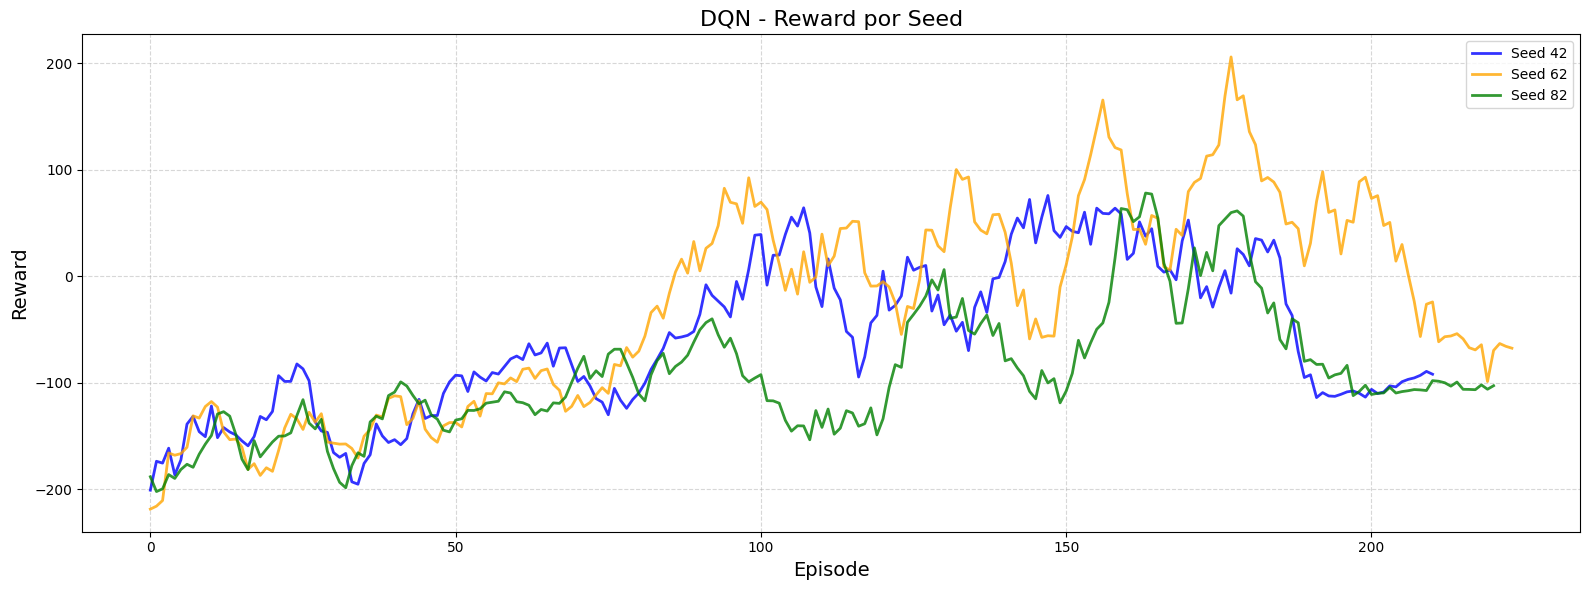

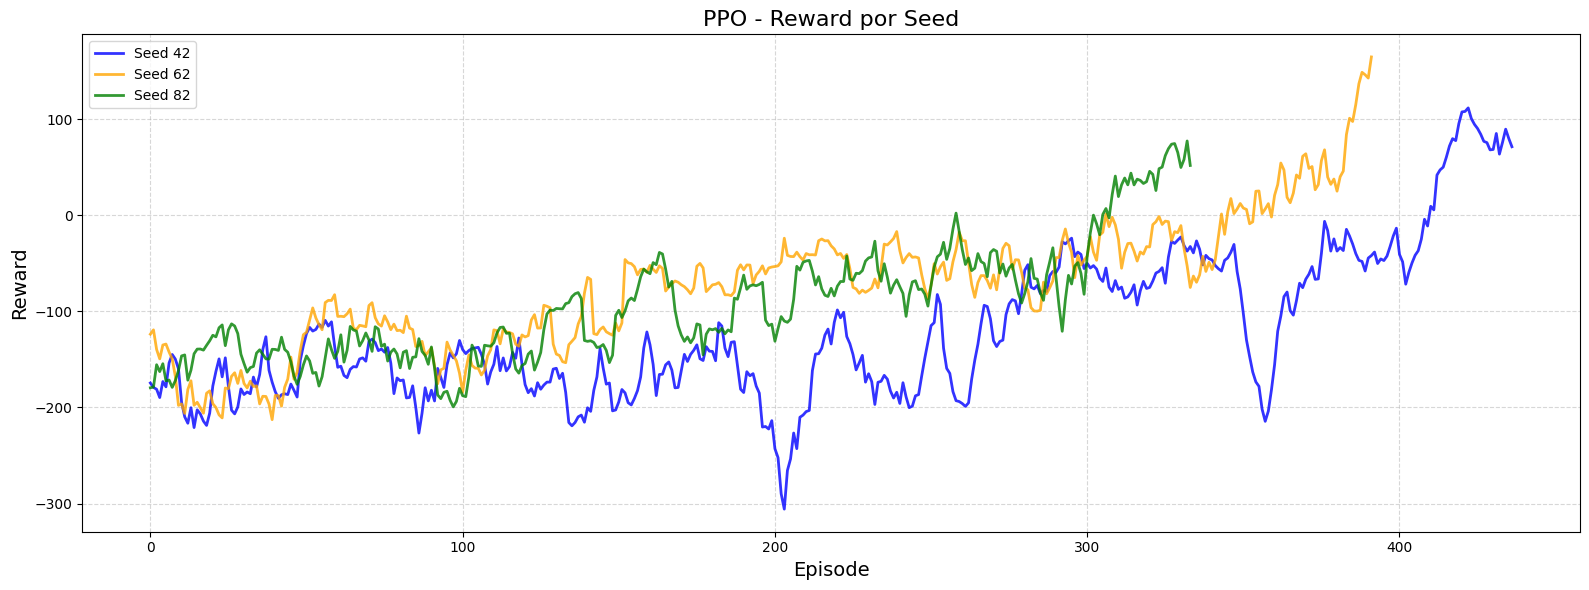

In [11]:
plot_seeds(os.path.join(DQN_DIR, "training_curves.json"), "DQN - Reward por Seed")
plot_seeds(os.path.join(PPO_DIR, "training_curves.json"), "PPO - Reward por Seed")